In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import export_graphviz
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('hotel_bookings.csv')

In [3]:
data.head(10)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,...,No Deposit,NaN,NaN,0,Transient,107.0,0,0,Check-Out,2015-07-03
7,Resort Hotel,0,9,2015,July,27,1,0,2,2,...,No Deposit,303.0,NaN,0,Transient,103.0,0,1,Check-Out,2015-07-03
8,Resort Hotel,1,85,2015,July,27,1,0,3,2,...,No Deposit,240.0,NaN,0,Transient,82.0,0,1,Canceled,2015-05-06
9,Resort Hotel,1,75,2015,July,27,1,0,3,2,...,No Deposit,15.0,NaN,0,Transient,105.5,0,0,Canceled,2015-04-22


### 1. DATA CLEANING 

#### A) Handling outlier

In [4]:
# Handling outlier menggunakan IQR

data_clean = data.copy()
columns = [
    'lead_time',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'adults',
    'children',
    'babies',
    'adr',
]

for i in columns:
    q1 = data[i].quantile(0.25)
    q3 = data[i].quantile(0.75)

    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    print(f'Lower point: {round(lower, 2)} \t upper point: {round(upper, 2)} \t {i}')
    
    if lower == upper:
        continue
    
    cond1 = (data_clean[i] >= lower) & (data_clean[i] <= upper)
    cond2 = data_clean[i].isnull()
    data_clean = data_clean[cond1 | cond2]

Lower point: -195.0 	 upper point: 373.0 	 lead_time
Lower point: -3.0 	 upper point: 5.0 	 stays_in_weekend_nights
Lower point: -2.0 	 upper point: 6.0 	 stays_in_week_nights
Lower point: 2.0 	 upper point: 2.0 	 adults
Lower point: 0.0 	 upper point: 0.0 	 children
Lower point: 0.0 	 upper point: 0.0 	 babies
Lower point: -15.77 	 upper point: 211.06 	 adr


#### B) Handling missing value

In [5]:
# Mengecek missing value
data_clean.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              467
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              15552
company         

* Handling missing value pada feature *company*

Terdapat **112593** missing value. Karena jumlahnya terlalu banyak, maka tidak bisa diisi berdasarkan feature lain ataupun menggunakan mean, median, modus. Maka opsi yang saya lakukan adalah **drop**. 

In [6]:
# Cek missing value pada feature company
data_clean['company'].isna().sum()

102741

In [7]:
# Drop
data_clean = data_clean.drop(['company'], axis=1)

* Handling missing value pada feature *children*

Terdapat **4** missing values pada feature children. Kemungkinan karena memang customer tersebut tidak memiliki anak. Jadi saya isi dengan **0**.

In [8]:
# Cek missing value pada feature children
data_clean['children'].isna().sum()

4

In [9]:
# Isi dengan 0
data_clean['children'] = data['children'].fillna(0)

* Handling missing value pada feature *country*

Terdapat **488** missing value pada feature country. Karena tidak bisa diisi berdasarkan feature lain, jadi saya isikan **"Unknown"**.

In [10]:
data_clean['country'].isna().sum()

467

In [11]:
data_clean['country'] = data_clean['country'].fillna('Unknown')

* Handling missing value pada feature *agent*

Terdapat **16340** missing values pada feature agent. Saya isi dengan **0**.

In [12]:
data_clean['agent'].isna().sum()

15552

In [13]:
data_clean['agent'] = data['agent'].fillna(0)

### 2. EXPLORATORY DATA ANALYSIS

**A) Lead Time**

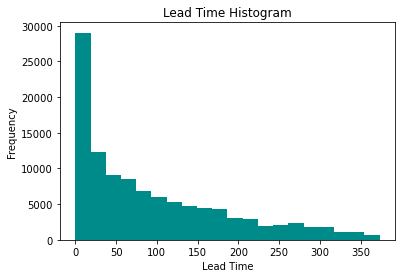

In [14]:
plt.hist(data_clean['lead_time'], color='darkcyan', bins=20)
plt.title('Lead Time Histogram')
plt.xlabel('Lead Time')
plt.ylabel('Frequency')
plt.show()

In [15]:
data_clean[['lead_time','is_canceled']].corr()

,lead_time,is_canceled
lead_time,1.000000,0.298541
is_canceled,0.298541,1.000000


#### Kesimpulan:
**Lead Time** berpengaruh signifikan terhadap variabel target.

**B) Time-Dependent Variables**

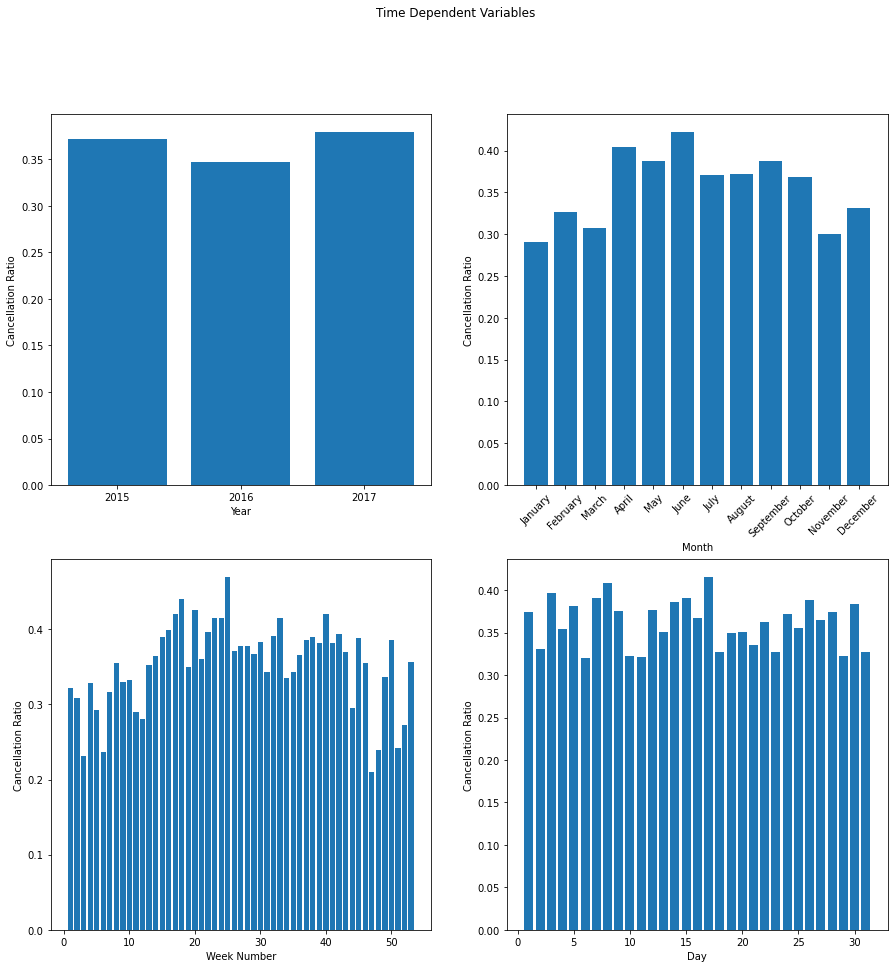

In [16]:
yearly_cancel_rate = data_clean.groupby(data_clean['arrival_date_year'])['is_canceled'].mean()
monthly_cancel_rate = data_clean.groupby(data_clean['arrival_date_month'])['is_canceled'].mean()
monthly_cancel_rate = monthly_cancel_rate[['January','February','March','April','May','June','July','August',
                           'September','October','November','December']]
weekly_cancel_rate = data_clean.groupby(data_clean['arrival_date_week_number'])['is_canceled'].mean()
daily_cancel_rate = data_clean.groupby(data_clean['arrival_date_day_of_month'])['is_canceled'].mean()

fig, ax = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Time Dependent Variables')
ax[0,0].bar(yearly_cancel_rate.index, yearly_cancel_rate)
ax[0,0].set_xticks([2015,2016,2017])
ax[0,0].set_xlabel('Year')
ax[0,0].set_ylabel('Cancellation Ratio')

ax[0,1].bar(monthly_cancel_rate.index, monthly_cancel_rate)
ax[0,1].tick_params(axis='x',rotation=45)
ax[0,1].set_xlabel('Month')
ax[0,1].set_ylabel('Cancellation Ratio')


ax[1,0].bar(weekly_cancel_rate.index, weekly_cancel_rate)
ax[1,0].set_xlabel('Week Number')
ax[1,0].set_ylabel('Cancellation Ratio')

ax[1,1].bar(daily_cancel_rate.index, daily_cancel_rate)
ax[1,1].set_xlabel('Day')
ax[1,1].set_ylabel('Cancellation Ratio')
plt.show()

#### Kesimpulan:
* Terdapat tren peningkatan pembatalan dari tahun 2015 hingga 2017, tetapi karena kurangnya data historis *Year*, saya tidak akan menggunakan feature ini untuk modeling.
* Ada perbedaan jumlah cancel setiap musim. Terutama bulan dan minggu musim semi dan musim panas cenderung memiliki lebih banyak pembatalan
* Variabel *Day* tidak berpengaruh banyak.

**C) Weekend vs Week**

In [17]:
data_clean['weekend_week_rto'] = data_clean['stays_in_weekend_nights'] / data_clean['stays_in_weekend_nights']
data_clean['weekend_week_rto'] = data_clean['weekend_week_rto'].fillna(0)

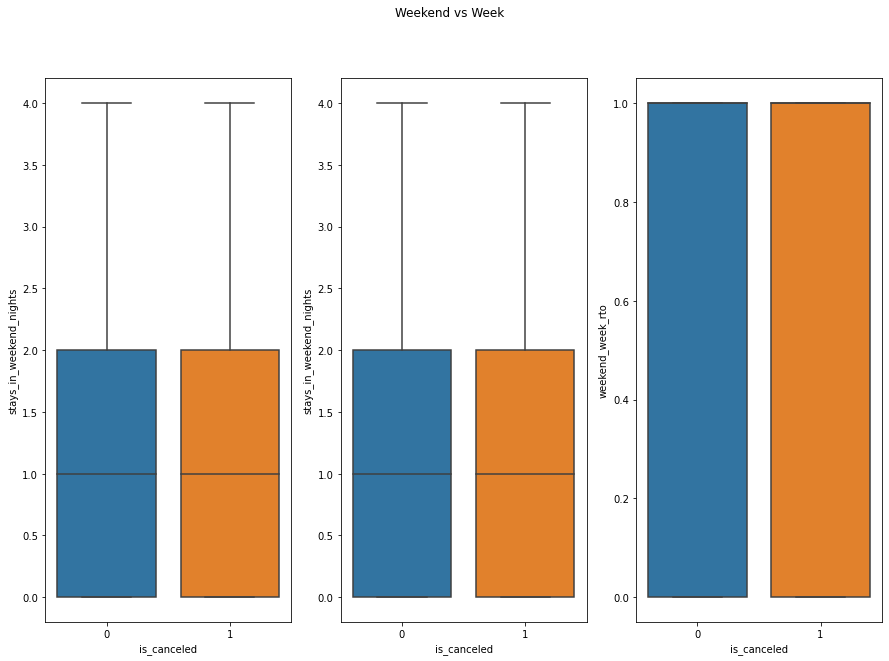

In [18]:
fig, ax = plt.subplots(1,3,figsize=(15,10))
fig.suptitle('Weekend vs Week')
sns.boxplot(ax=ax[0],x="is_canceled", y='stays_in_weekend_nights', data=data_clean)
sns.boxplot(ax=ax[1],x="is_canceled", y='stays_in_weekend_nights', data=data_clean)
sns.boxplot(ax=ax[2],x="is_canceled", y='weekend_week_rto', data=data_clean)
plt.show()

In [19]:
data_clean[['stays_in_weekend_nights','weekend_week_rto','is_canceled']].corr()

,stays_in_weekend_nights,weekend_week_rto,is_canceled
stays_in_weekend_nights,1.000000,0.880058,0.005392
weekend_week_rto,0.880058,1.000000,0.000369
is_canceled,0.005392,0.000369,1.000000


#### **Kesimpulan:**
**weekend_week_rto** dan **stays_in_weekend_nights** tidak berpengaruh terhadap variabel target.

**D) Number of People**

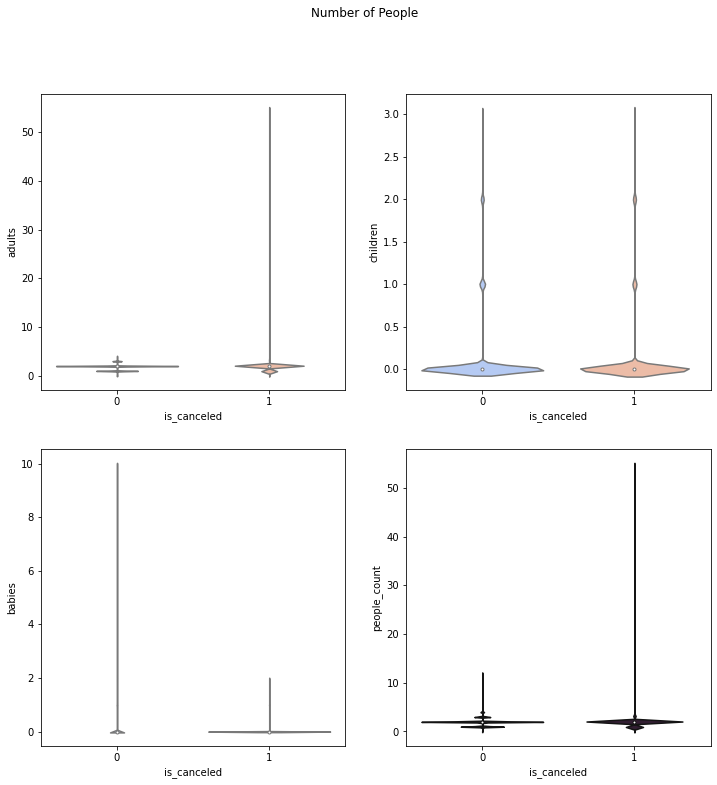

In [20]:
data_clean['people_count'] = data_clean['adults'] + data_clean['children'] + data_clean['babies']
fig, ax = plt.subplots(2,2,figsize=(12,12))
fig.suptitle('Number of People')
sns.set_palette(sns.color_palette("coolwarm", 2))
sns.violinplot(ax=ax[0,0],x="is_canceled", y='adults', data=data_clean)
sns.violinplot(ax=ax[0,1],x="is_canceled", y='children', data=data_clean)
sns.violinplot(ax=ax[1,0],x="is_canceled", y='babies', data=data_clean)
sns.set_palette(sns.dark_palette("purple"))
sns.violinplot(ax=ax[1,1],x="is_canceled", y='people_count', data=data_clean)
plt.show()

In [21]:
data_clean[['people_count','is_canceled']].corr()

,people_count,is_canceled
people_count,1.000000,0.047742
is_canceled,0.047742,1.000000


#### Kesimpulan: 
Terdapat pengaruh **people_count** terhadap variabel target. Karena semakin banyak orang dalam satu booking, semakin besar kemungkinan pembatalan. 

**E) Meals**

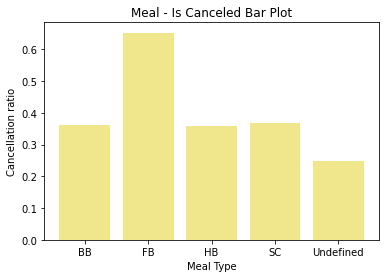

meal
BB           85398
FB             700
HB           11766
SC           10506
Undefined     1055
Name: meal, dtype: int64


In [22]:
meal = data_clean.groupby(data['meal']).mean()['is_canceled']
plt.bar(x=meal.index, height=meal.values, color='khaki')
plt.title('Meal - Is Canceled Bar Plot')
plt.xlabel('Meal Type')
plt.ylabel('Cancellation ratio')
plt.show()

print(data_clean['meal'].groupby(data_clean['meal']).count())

#### Kesimpulan:

Terdapat pengaruh **meal** terhadap variabel target.

**F) Distribution Channel**

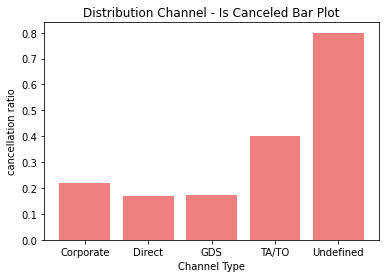

In [23]:
distchan = data_clean.groupby(data_clean['distribution_channel']).mean()['is_canceled']
plt.bar(x=distchan.index, height=distchan.values, color='lightcoral')
plt.title('Distribution Channel - Is Canceled Bar Plot')
plt.xlabel('Channel Type')
plt.ylabel('cancellation ratio')
plt.show()

#### Kesimpulan
Terdapat pengaruh **Distribution Channel** terhadap variabel target.

**G) Repeated Guest or Not**

Text(0, 0.5, 'Cancellation Ratio')

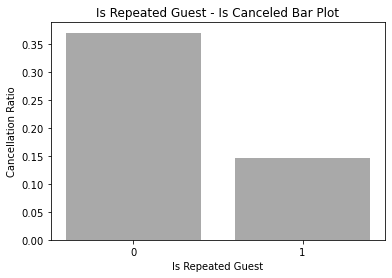

In [24]:
rep = data_clean.groupby(data['is_repeated_guest']).mean()['is_canceled']
plt.bar(x=rep.index, height=rep.values, color='darkgray')
plt.xticks([0,1])
plt.title('Is Repeated Guest - Is Canceled Bar Plot')
plt.xlabel('Is Repeated Guest')
plt.ylabel('Cancellation Ratio')

#### Kesimpulan:
Customer yang pernah booking sebelumnya tingkat pembatalannya semakin kecil. 

**H) Past Cancellations**

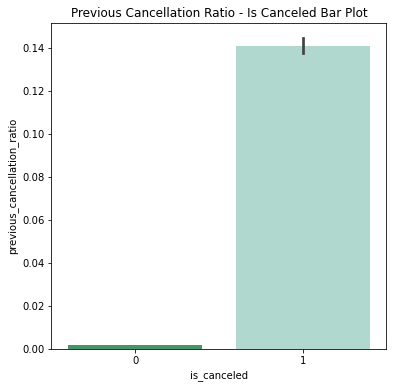

In [25]:
# With the PreeviousCancellations and PreviusBookingsNotCanceled variable, we may compute the ratio
cancel_rto = data_clean['previous_cancellations'] / (data_clean['previous_cancellations'] + data_clean['previous_bookings_not_canceled'])
cancel_rto = cancel_rto.fillna(0)
data_clean['previous_cancellation_ratio'] = cancel_rto

sns.set_palette(sns.color_palette("BuGn_r", 2))
fig, ax = plt.subplots(1,1,figsize=(6,6))
plt.title('Previous Cancellation Ratio - Is Canceled Bar Plot')
sns.barplot(x="is_canceled", y='previous_cancellation_ratio', data=data_clean)
plt.show()

#### Kesimpulan:
Customer yang pernah melakukan pembatalan sebelumnya, semakin besar kemungkinan akan melakukan pembatalan lagi.

**I) Booking Changes**

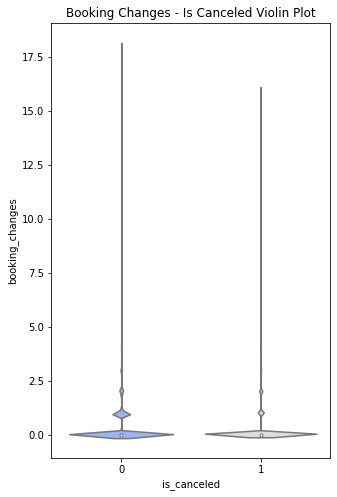

In [26]:
fig, ax = plt.subplots(figsize=(5,8))
sns.set_palette(sns.color_palette("coolwarm", 3))
sns.violinplot(x="is_canceled", y='booking_changes', data=data_clean)
plt.title('Booking Changes - Is Canceled Violin Plot')
plt.show()

#### Kesimpulan:
**Booking Changes** tidak terlalu signifikan terhadap variabel target

**J) Payment Condition**

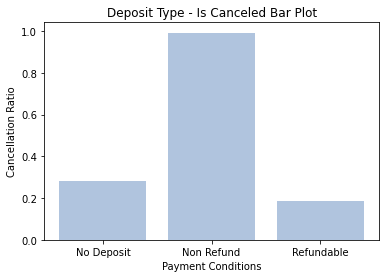

In [27]:
deptype = data_clean.groupby(data_clean['deposit_type']).mean()['is_canceled']
plt.bar(x=deptype.index, height=deptype.values, color='lightsteelblue')
plt.title('Deposit Type - Is Canceled Bar Plot')
plt.xlabel('Payment Conditions')
plt.ylabel('Cancellation Ratio')
plt.show()

In [28]:
data_clean['deposit_type'].groupby(data_clean['deposit_type']).count()

deposit_type
No Deposit    96526
Non Refund    12747
Refundable      152
Name: deposit_type, dtype: int64

#### Kesimpulan:
Kenapa **Non-Refund Payment Conditions memiliki tingkat pembatalan yang lebih tinggi?** Kemungkinan pihak hotel menetapkan tidak dapat memberikan refund kepada customer dalam periode waktu tertentu di mana sebagian besar customer cenderung membatalkan reservasi.

**K) Days in Waiting List**

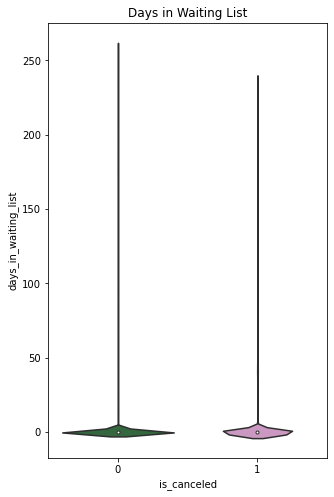

In [29]:
fig, ax = plt.subplots(figsize=(5,8))
sns.set_palette(sns.color_palette("cubehelix", 2))
sns.violinplot(x="is_canceled", y='days_in_waiting_list', data=data_clean)
plt.title('Days in Waiting List')
plt.show()

#### Kesimpulan:
Semakin lama waktu tunggu, tingkat pembatalan semakin kecil. Menurut opini saya kemungkinan customer tidak ingin membatalkan reservasi yang sudah ditunggu sejak lama.

**L) Customer Type**

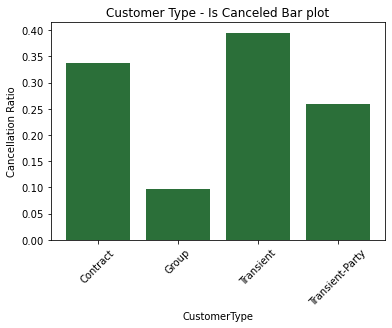

customer_type
Contract            3388
Group                547
Transient          82153
Transient-Party    23337
Name: is_canceled, dtype: int64


In [30]:
custtype = data_clean.groupby(data_clean['customer_type']).mean()['is_canceled']
plt.bar(x=custtype.index, height=custtype.values)
plt.xticks(rotation=45)
plt.title('Customer Type - Is Canceled Bar plot')
plt.xlabel("CustomerType")
plt.ylabel('Cancellation Ratio')
plt.show()
print(data.groupby(data_clean['customer_type']).count()['is_canceled'])

#### Kesimpulan:
Customer yang bertipe **Transient** cenderung lebih sering membatalkan reservasi.

**M) Average Daily Rate (ADR)**

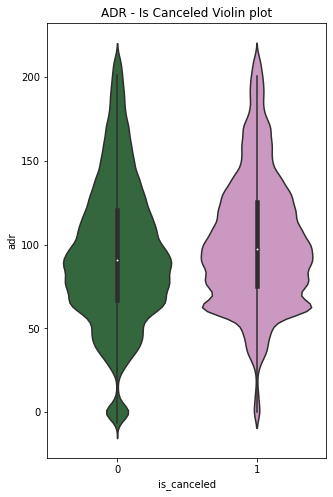

In [31]:
fig, ax = plt.subplots(figsize=(5,8))
sns.violinplot(x="is_canceled", y='adr', data=data_clean)
plt.title('ADR - Is Canceled Violin plot')
plt.show()

#### Kesimpulan:
Average Daily Rate tidak memiliki pengaruh terhadap variabel target

**N) Parking Space Requested**

In [32]:
data_clean[['required_car_parking_spaces', 'people_count']].corr()

,required_car_parking_spaces,people_count
required_car_parking_spaces,1.000000,0.035114
people_count,0.035114,1.000000


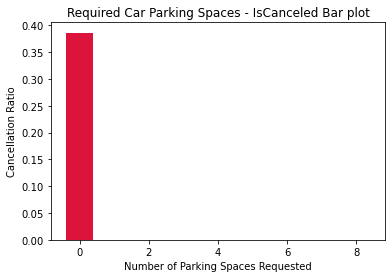

In [33]:
parking = data_clean.groupby(data_clean['required_car_parking_spaces']).mean()['is_canceled']
plt.bar(x=parking.index, height=parking.values, color='crimson')
plt.title('Required Car Parking Spaces - IsCanceled Bar plot')
plt.xlabel('Number of Parking Spaces Requested')
plt.ylabel('Cancellation Ratio')
plt.show()

#### Kesimpulan:
**Parking Space Requested** tidak terdapat pengaruh terhadap variabel target.

**O) Number of Specific Requests**

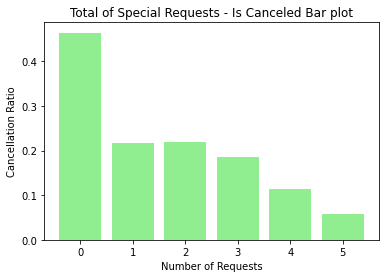

In [34]:
specreq = data_clean.groupby(data_clean['total_of_special_requests']).mean()['is_canceled']
plt.bar(x=specreq.index, height=specreq.values, color='lightgreen')
plt.xlabel('Number of Requests')
plt.ylabel('Cancellation Ratio')
plt.title('Total of Special Requests - Is Canceled Bar plot')
plt.show()

#### Kesimpulan: 
Semakin banyak permintaan tambahan dari customer (seperti twin bed, makanan khusus, dll.), Semakin kecil customer membatalkan reservasi.

**P) Market Segment**

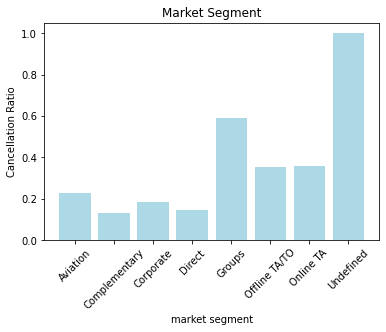

market_segment
Aviation           214
Complementary      736
Corporate         5201
Direct           11374
Groups           17491
Offline TA/TO    21937
Online TA        52470
Undefined            2
Name: market_segment, dtype: int64


In [35]:
marketseg = data_clean.groupby(data_clean['market_segment']).mean()['is_canceled']
plt.bar(x=marketseg.index, height=marketseg.values, color='lightblue')
plt.xticks(rotation=45)
plt.title('Market Segment')
plt.xlabel('market segment')
plt.ylabel('Cancellation Ratio')
plt.show()

print(data_clean['market_segment'].groupby(data_clean['market_segment']).count())

#### Kesimpulan:
Jenis segmen market tertentu memiliki rasio pembatalan yang lebih tinggi.

In [36]:
np.unique(data_clean['is_canceled'])

array([0, 1], dtype=int64)

### 3. BUILDING MODEL & HYPER-PARAMETER TUNING

#### A) Preprocess Features

In [37]:
# month to season
spr_sum = ['March','April','May','June','July','August']  # 1
fal_win = ['September','October','November','December','January','February']  # 0
data_clean['arrival_season'] = data_clean['arrival_date_month'].apply(lambda x : int(x in spr_sum))

# Reduce Marketsegment
ones = ['Online TA','Groups']
data_clean['MarketSegENC'] = data_clean['market_segment'].apply(lambda x : int(x in ones))

# Deposit type to binary : Non-refundable or Not
data_clean['NonRefundable'] = data_clean['deposit_type'].apply(lambda x : int(x == 'Non Refund'))

# Transient Customers or Not
ones = ['Transient','Transient-Party']
data_clean['TransientCust'] = data_clean['customer_type'].apply(lambda x : int(x in ones))

# Required Parking Space or Not
data_clean['NeedParking'] = data_clean['required_car_parking_spaces'].apply(lambda x : int(x != 0))

#### B) Feature Selection

In [38]:
data_clean.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'weekend_week_rto',
       'people_count', 'previous_cancellation_ratio', 'arrival_season',
       'MarketSegENC', 'NonRefundable', 'TransientCust', 'NeedParking'],
      dtype='object')

In [39]:
usecols = ['is_canceled','lead_time','arrival_season','people_count','meal','MarketSegENC','distribution_channel',
           'is_repeated_guest','previous_cancellation_ratio','NonRefundable','days_in_waiting_list',
           'TransientCust','NeedParking']
data_ready = data_clean[usecols]
data_ready.head()

,is_canceled,lead_time,arrival_season,people_count,meal,MarketSegENC,distribution_channel,is_repeated_guest,previous_cancellation_ratio,NonRefundable,days_in_waiting_list,TransientCust,NeedParking
0,0,342,1,2.0,BB,0,Direct,0,0.0,0,0,1,0
2,0,7,1,1.0,BB,0,Direct,0,0.0,0,0,1,0
3,0,13,1,1.0,BB,0,Corporate,0,0.0,0,0,1,0
4,0,14,1,2.0,BB,1,TA/TO,0,0.0,0,0,1,0
5,0,14,1,2.0,BB,1,TA/TO,0,0.0,0,0,1,0


#### C) To Dummy Variables (One-Hot Variables)
We did not set drop_first=True for interpretability

In [40]:
data_onehot = pd.get_dummies(data_ready, columns=['meal','distribution_channel'])
data_onehot.head()

,is_canceled,lead_time,arrival_season,people_count,MarketSegENC,is_repeated_guest,previous_cancellation_ratio,NonRefundable,days_in_waiting_list,TransientCust,...,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined
0,0,342,1,2.0,0,0,0.0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
2,0,7,1,1.0,0,0,0.0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
3,0,13,1,1.0,0,0,0.0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
4,0,14,1,2.0,1,0,0.0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
5,0,14,1,2.0,1,0,0.0,0,0,1,...,1,0,0,0,0,0,0,0,1,0


#### D) Splitting the Data

In [41]:
X = data_onehot.iloc[:,1:]
y = data_onehot.iloc[:,0]
print('X shape : {}'.format(X.shape))
print('y shape : {}'.format(y.shape))

X shape : (109425, 20)
y shape : (109425,)


In [42]:
trainx, testx, trainy, testy = train_test_split(X, y, test_size=0.25, random_state=1234)
print('Train X shape : {}'.format(trainx.shape))
print('Train y shape : {}'.format(trainy.shape))
print('Test X shape : {}'.format(testx.shape))
print('Test y shape : {}'.format(testy.shape))

Train X shape : (82068, 20)
Train y shape : (82068,)
Test X shape : (27357, 20)
Test y shape : (27357,)


#### E) Standardize Input Scales

In [43]:
scaler = StandardScaler()
trainx_scaled = scaler.fit_transform(trainx)
testx_scaled = scaler.transform(testx)

#### F) Modeling
Saya memutuskan menggunakan 2 model berbeda dan memilih yang terbaik.

* **Logistic Regression**

In [44]:
lr = LogisticRegression(max_iter=1000)
lr.fit(trainx_scaled, trainy)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
tr_pred = lr.predict(trainx_scaled)
te_pred = lr.predict(testx_scaled)
print('Train Accuracy = {}'.format(accuracy_score(tr_pred, trainy)))
print('Test Accuracy = {}'.format(accuracy_score(te_pred, testy)))
print(classification_report(te_pred, testy))

Train Accuracy = 0.7738948189306429
Test Accuracy = 0.7757429542713017
              precision    recall  f1-score   support

           0       0.98      0.75      0.85     22901
           1       0.42      0.93      0.57      4456

    accuracy                           0.78     27357
   macro avg       0.70      0.84      0.71     27357
weighted avg       0.89      0.78      0.80     27357



* **Decision Tree**

In [46]:
dt = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=6
)

dt_res = dt.fit(trainx_scaled, trainy)

In [47]:
tr_pred = dt.predict(trainx_scaled)
te_pred = dt.predict(testx_scaled)
print('Train Accuracy = {}'.format(accuracy_score(tr_pred, trainy)))
print('Test Accuracy = {}'.format(accuracy_score(te_pred, testy)))
print(classification_report(te_pred, testy))

Train Accuracy = 0.7717989959545742
Test Accuracy = 0.7719779215557261
              precision    recall  f1-score   support

           0       1.00      0.74      0.85     23606
           1       0.38      1.00      0.55      3751

    accuracy                           0.77     27357
   macro avg       0.69      0.87      0.70     27357
weighted avg       0.91      0.77      0.81     27357



#### G) K Fold Cross Validation with Decision Tree

In [48]:
dt = DecisionTreeClassifier(
    criterion='entropy',
)

tr_accs = []
te_accs = []
kfold = KFold(n_splits=10)
for idx, (tr_idx, te_idx) in enumerate(kfold.split(X)) :
    trainX = X.iloc[tr_idx, :]
    testX = X.iloc[te_idx, :]
    trainy = y.iloc[tr_idx]
    testy = y.iloc[te_idx]
    
    scaler = StandardScaler()
    trainX = scaler.fit_transform(trainX)
    testX = scaler.transform(testX)
    
    dt.fit(trainX, trainy)
    tr_pred = dt.predict(trainX)
    te_pred = dt.predict(testX)
    
    tr_acc = accuracy_score(tr_pred, trainy)
    te_acc = accuracy_score(te_pred, testy)
    tr_accs.append(tr_acc)
    te_accs.append(te_acc)
    print('Fold {} : Train Accuracy = {}'.format(idx+1, tr_acc))
    print('Fold {} : Test Accuracy = {}'.format(idx+1, te_acc))
    print()

print('K Fold Accuracy Mean : {}'.format(np.mean(te_accs)))
print('K Fold Accuracy Standard Deviation : {}'.format(np.std(te_accs)))

Fold 1 : Train Accuracy = 0.8535163786275665
Fold 1 : Test Accuracy = 0.43205702275427216

Fold 2 : Train Accuracy = 0.8131739810320667
Fold 2 : Test Accuracy = 0.8727040116969752

Fold 3 : Train Accuracy = 0.8144940192116326
Fold 3 : Test Accuracy = 0.8265557890889152

Fold 4 : Train Accuracy = 0.8317865193639447
Fold 4 : Test Accuracy = 0.6998994791190716

Fold 5 : Train Accuracy = 0.8542068601368779
Fold 5 : Test Accuracy = 0.4116786987115051

Fold 6 : Train Accuracy = 0.8615395550501102
Fold 6 : Test Accuracy = 0.35386583805520017

Fold 7 : Train Accuracy = 0.8090634931917183
Fold 7 : Test Accuracy = 0.9258819228660209

Fold 8 : Train Accuracy = 0.8222942030604267
Fold 8 : Test Accuracy = 0.6816852494973497

Fold 9 : Train Accuracy = 0.8261628910573399
Fold 9 : Test Accuracy = 0.6188082617437397

Fold 10 : Train Accuracy = 0.8297878821725577
Fold 10 : Test Accuracy = 0.6004386766587461

K Fold Accuracy Mean : 0.6423574950191797
K Fold Accuracy Standard Deviation : 0.188470307538174

#### H) Hyper-Parameter Tuning

In [49]:
# parameter model linear regression yang akan dituned + nilai yang mungkin

penalty = ['l1', 'l2', 'elasticnet', 'none']
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
max_iter = [1, 10, 100, 1000, 10000]

param = {'penalty': penalty, 'solver': solver, 'max_iter': max_iter}
param

{'penalty': ['l1', 'l2', 'elasticnet', 'none'],
 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
 'max_iter': [1, 10, 100, 1000, 10000]}

In [50]:
# mencari parameter terbaik pada model: logistic regression

from sklearn.model_selection import RandomizedSearchCV
model_dtc = DecisionTreeClassifier()
model_dtc_rs = RandomizedSearchCV(estimator = model_dtc, param_distributions= param, cv = 5)

### 4. MODEL EVALUATION & IMPLEMENTATION

#### Kesimpulan:

Berdasarkan perbandingan score dari 2 model diatas. Hasilnya keduanya tidak terlalu jauh yaitu akurasi skor 77%. 
Kesalahan yang akan ditekan pada kasus ini adalah: Customer akan cancel booking (membatalkan pesanan), padahal sebenarnya/realisasinya user tidak membatalkan pesanan, karena berdasarkan artikel dari **bisnis.com** pembatalan pemesanan kamar hotel pada menit-menit terakhir yang menjadi tren dalam beberapa tahun terakhir merupakan masalah bagi pelaku usaha perhotelan. Pembatalan itu tidak saja berpotensi menurunkan pendapatan industri jasa tersebut, namun juga mengganggu manajemen keuangan sektor usaha tersebut. 